In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd


In [27]:
torch.manual_seed(42)

BATCH_SIZE = 64

transform = transforms.Compose([
    transforms.Resize((16, 16)),  # Ensure images are resized to 16x16
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])

data_root  = "../../mega_batch"               # <-- your folder
full_ds    = datasets.ImageFolder(data_root, transform=transform)

# Calculate lengths for train, validation, and test splits
train_len = int(0.8 * len(full_ds))
test_len = len(full_ds) - train_len  # Remaining samples for the test set

# Split the dataset
train_set, test_set = random_split(full_ds, [train_len, test_len])

# Create DataLoaders for each set
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Class mapping:", full_ds.class_to_idx              # Option A
      if isinstance(train_set, torch.utils.data.Subset)   
      else train_set.class_to_idx)

Class mapping: {'lebron': 0, 'other': 1}


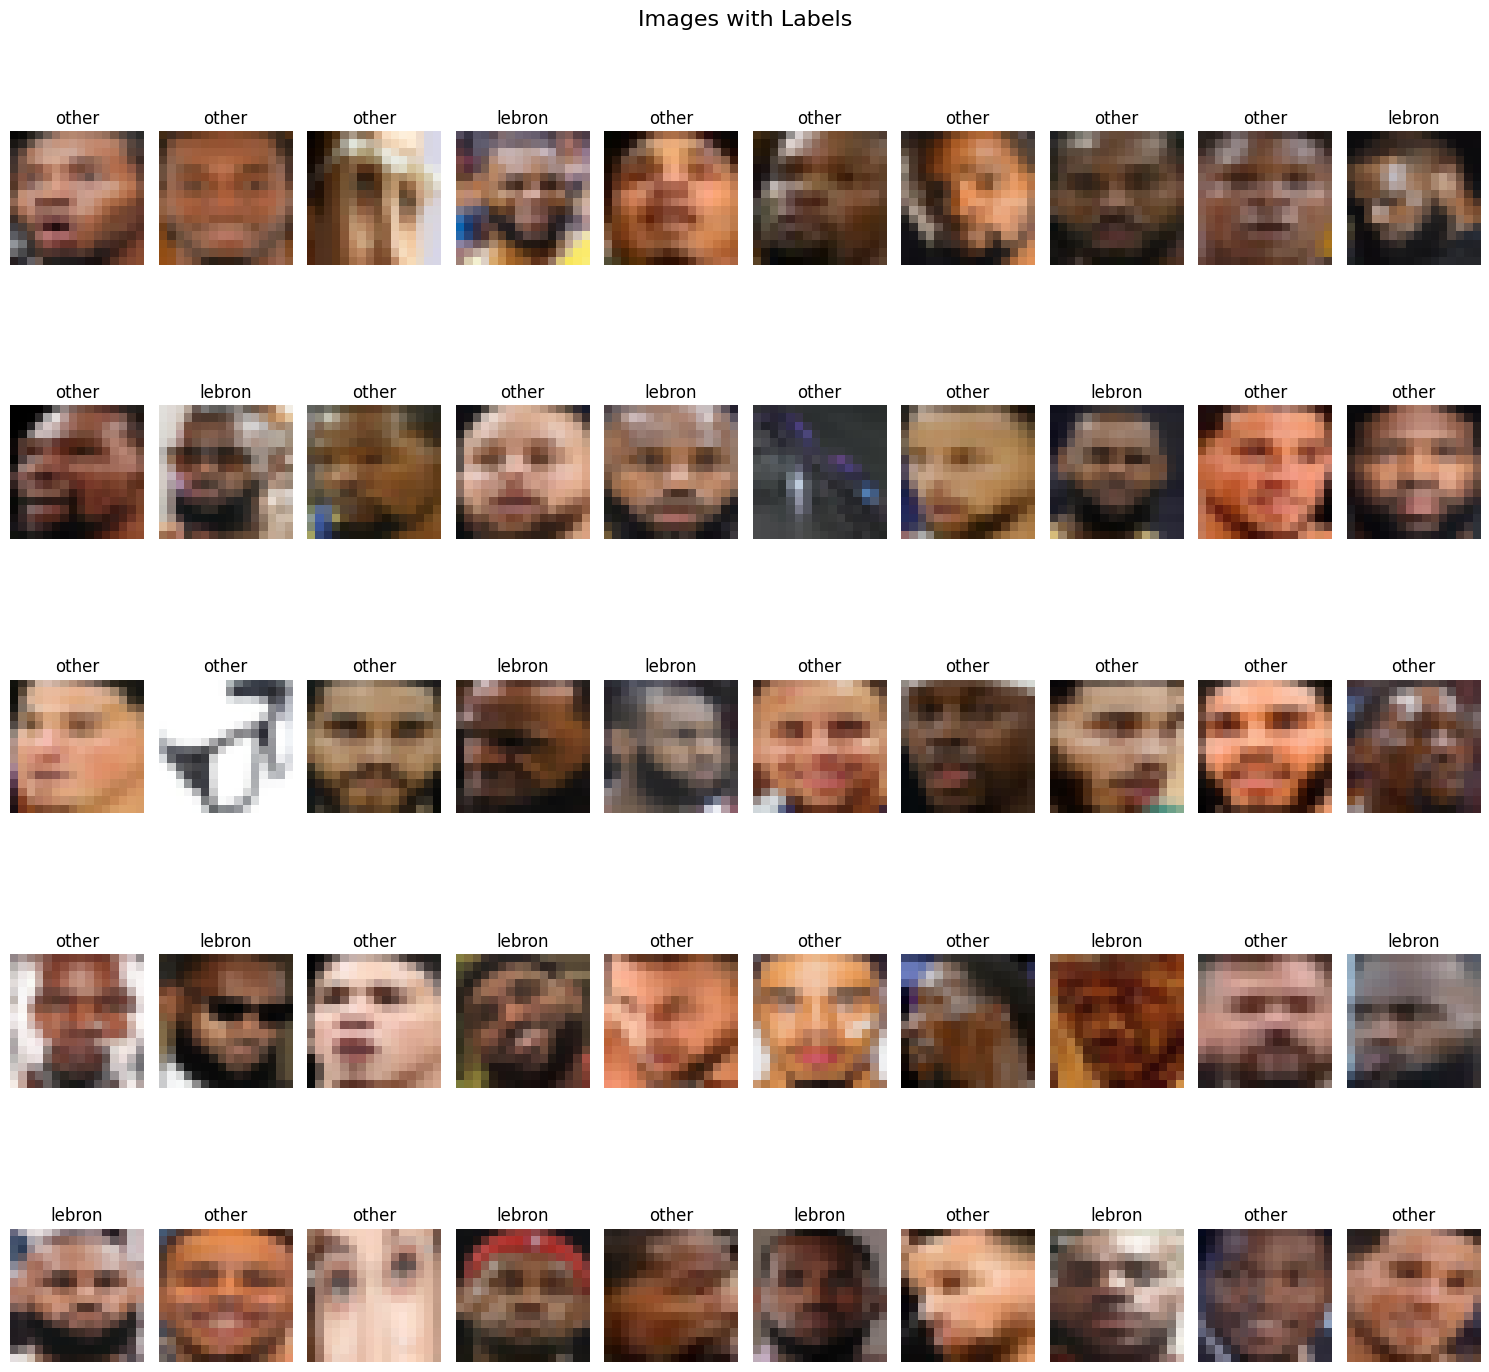

In [28]:
import matplotlib.pyplot as plt

def display_training_images(dataset, idx_to_class, num_images=10, images_per_row=10):
    """
    Displays images from the training set with their corresponding labels.

    Parameters:
    - dataset: The dataset (e.g., train_set).
    - idx_to_class: A dictionary mapping class indices to class names.
    - num_images: Number of images to display.
    """
    num_rows = math.ceil(num_images / images_per_row)  # Calculate the number of rows
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))
    fig.suptitle("Images with Labels", fontsize=16)

    for i in range(num_images):
        row = i // images_per_row
        col = i % images_per_row
        img, label = dataset[i]  # Get image and label
        img = img.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Unnormalize the image

        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        axes[row, col].set_title(idx_to_class[label])

    # Hide unused axes
    for i in range(num_images, num_rows * images_per_row):
        row = i // images_per_row
        col = i % images_per_row
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Define idx_to_class
idx_to_class = {v: k for k, v in full_ds.class_to_idx.items()}

# Call the function to display images
display_training_images(test_set, idx_to_class, num_images=50)

In [29]:
from collections import Counter

# Function to calculate class distribution
def get_class_distribution(dataset):
    targets = [label for _, label in dataset]
    return Counter(targets)

# Print class distribution for each dataset
print("Class distribution in Training set:", get_class_distribution(train_set))
print("Class distribution in Test set:", get_class_distribution(test_set))

Class distribution in Training set: Counter({1: 938, 0: 292})
Class distribution in Test set: Counter({1: 228, 0: 80})


In [30]:
class SimpleBinaryCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),  # Reduced filters to 64
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),  # Reduced filters to 128
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),  # Reduced filters to 256
            nn.MaxPool2d(2),
        )
        
        # Manually calculated flattened size: 2 * 2 * 256 = 1024
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2 * 2 * 256, 256), nn.ReLU(),  # Reduced fully connected layer size
            nn.Dropout(0.25),
            nn.Linear(256, 128), nn.ReLU(),  # Reduced fully connected layer size
            nn.Dropout(0.25),
            nn.Linear(128, 1)  # Single output logit
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = SimpleBinaryCNN().to(device)

learning_rate = 1e-3
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


cuda


# Training

In [32]:
# Initialize lists to store metrics
train_losses = []
train_accuracies = []
test_accuracies = []

EPOCHS = 25

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct = 0.0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = (torch.sigmoid(logits) > 0.5).float()
        correct += (preds == labels).sum().item()

    train_loss = running_loss / len(train_set)
    train_acc = correct / len(train_set)

    # --- quick validation ---
    model.eval()

    # --- test evaluation ---
    test_correct = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.float().unsqueeze(1).to(device)
            logits = model(imgs)
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == labels).sum().item()
    test_acc = test_correct / len(test_set)

    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"train_loss: {train_loss:.3f} | train_acc: {train_acc:.3f} | "
          f"test_acc: {test_acc:.3f}")

Epoch 1/25 | train_loss: 0.425 | train_acc: 0.789 | test_acc: 0.740
Epoch 2/25 | train_loss: 0.273 | train_acc: 0.885 | test_acc: 0.740
Epoch 3/25 | train_loss: 0.180 | train_acc: 0.924 | test_acc: 0.834
Epoch 4/25 | train_loss: 0.154 | train_acc: 0.947 | test_acc: 0.782
Epoch 5/25 | train_loss: 0.136 | train_acc: 0.944 | test_acc: 0.919
Epoch 6/25 | train_loss: 0.079 | train_acc: 0.973 | test_acc: 0.951
Epoch 7/25 | train_loss: 0.063 | train_acc: 0.975 | test_acc: 0.935
Epoch 8/25 | train_loss: 0.040 | train_acc: 0.989 | test_acc: 0.747
Epoch 9/25 | train_loss: 0.101 | train_acc: 0.963 | test_acc: 0.942
Epoch 10/25 | train_loss: 0.033 | train_acc: 0.987 | test_acc: 0.942
Epoch 11/25 | train_loss: 0.051 | train_acc: 0.983 | test_acc: 0.919
Epoch 12/25 | train_loss: 0.056 | train_acc: 0.980 | test_acc: 0.909
Epoch 13/25 | train_loss: 0.048 | train_acc: 0.985 | test_acc: 0.948
Epoch 14/25 | train_loss: 0.025 | train_acc: 0.992 | test_acc: 0.948
Epoch 15/25 | train_loss: 0.010 | train_acc

In [43]:
import yaml
metrics = {
    '16x16': {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    }
}

# Load existing data if the file exists
try:
    with open('../../model_runs/training_metrics.yaml', 'r') as file:
        existing_metrics = yaml.safe_load(file) or {}
except FileNotFoundError:
    existing_metrics = {}

# Update the existing data with new metrics
existing_metrics.update(metrics)

# Write the updated data back to the file
with open('../../model_runs/training_metrics.yaml', 'w') as file:
    yaml.dump(existing_metrics, file)

# Results

In [34]:
# Collect true labels, predicted labels, and predicted probabilities
true_labels = []
predicted_labels = []
predicted_probs = []

model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.float().unsqueeze(1).to(device)
        logits = model(imgs)
        probs = torch.sigmoid(logits)  # Get probabilities
        preds = (probs > 0.5).float()  # Convert probabilities to binary predictions
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())
        predicted_probs.extend(probs.cpu().numpy())  # Save probabilities

In [36]:
# Generate the classification report as a dictionary
report = classification_report(true_labels, predicted_labels, target_names=["Other", "Lebron"], output_dict=True)

# Convert the report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# # Display the DataFrame as a table
# print(report_df)

# Optionally, if you're using Jupyter Notebook, you can display it as a styled table
from IPython.display import display
display(report_df.style.set_caption("Classification Report").format(precision=2))

# Calculate and print model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")

,precision,recall,f1-score,support
Other,0.97,0.86,0.91,80.00
Lebron,0.95,0.99,0.97,228.00
accuracy,0.96,0.96,0.96,0.96
macro avg,0.96,0.93,0.94,308.00
weighted avg,0.96,0.96,0.96,308.00



Total Parameters: 667137
Trainable Parameters: 667137


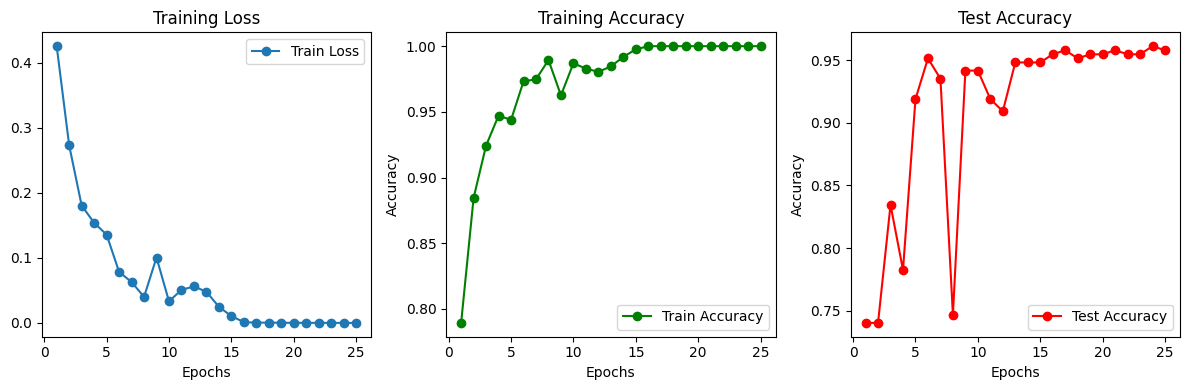

In [37]:
# Plot training loss, training accuracy, and test accuracy
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.xlabel('Epochs')
plt.title('Training Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

# Plot test accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

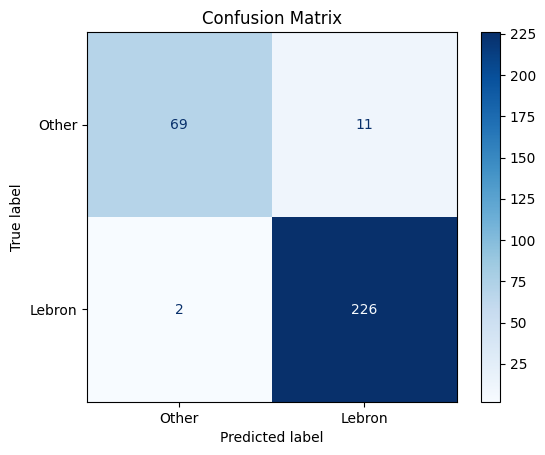

In [38]:
# Collect true labels and predictions
true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.float().unsqueeze(1).to(device)
        logits = model(imgs)
        preds = (torch.sigmoid(logits) > 0.5).float()
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Flatten the lists
true_labels = [int(label[0]) for label in true_labels]
predicted_labels = [int(pred[0]) for pred in predicted_labels]

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Other", "Lebron"])

disp.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)  # Turn off the grid
plt.title("Confusion Matrix")
plt.show()

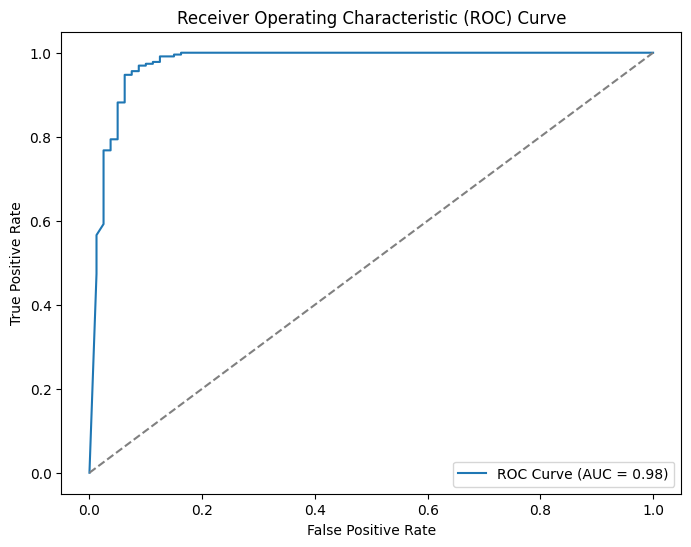

In [40]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

False Negatives (Lebron classified as not Lebron): 11


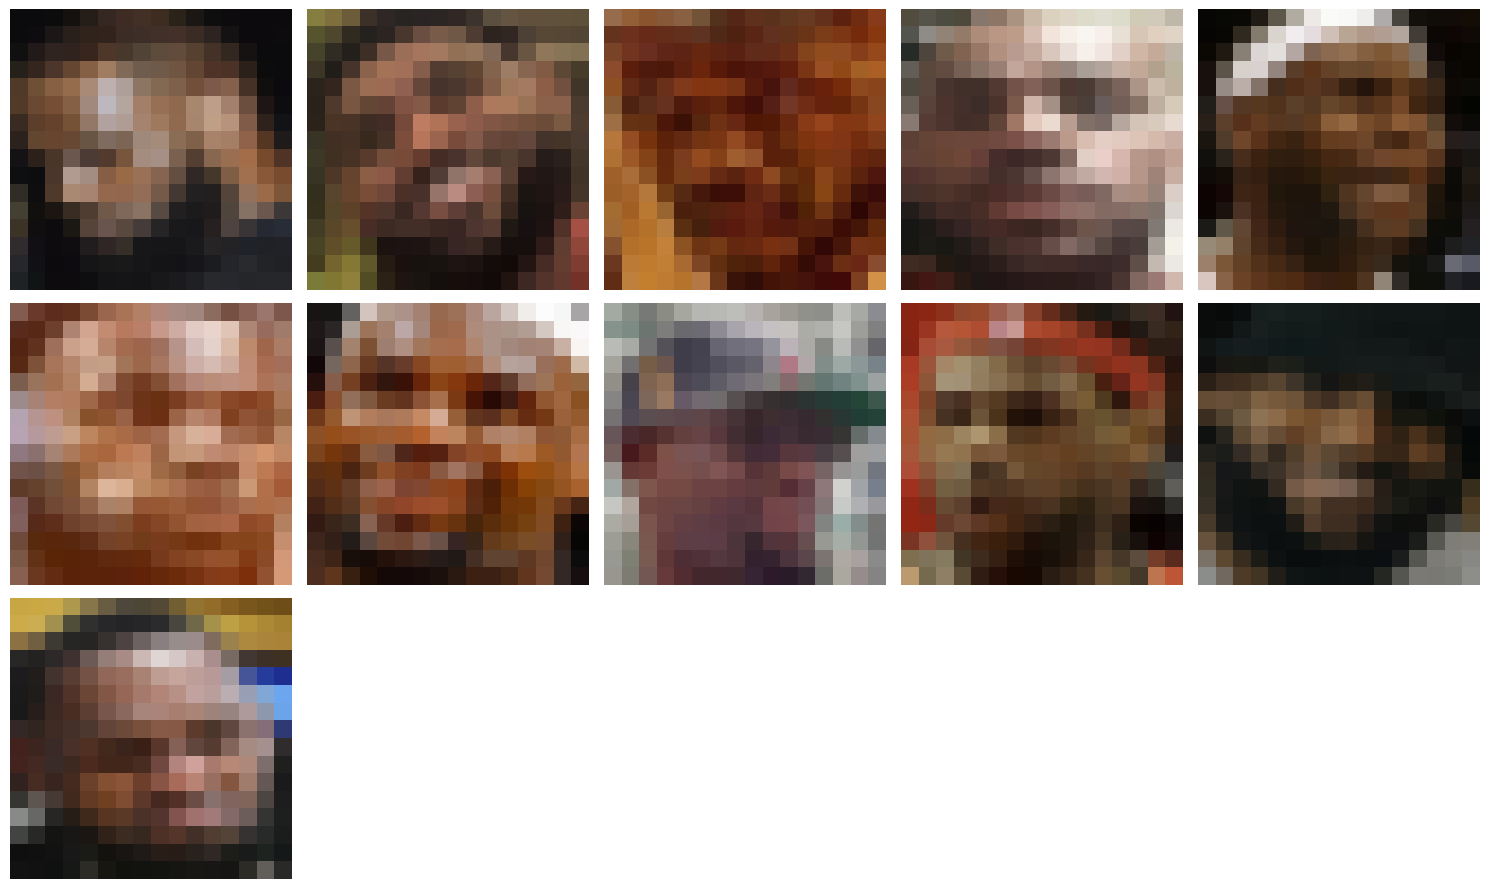

False Positives (NOT Lebron classified as Lebron): 2


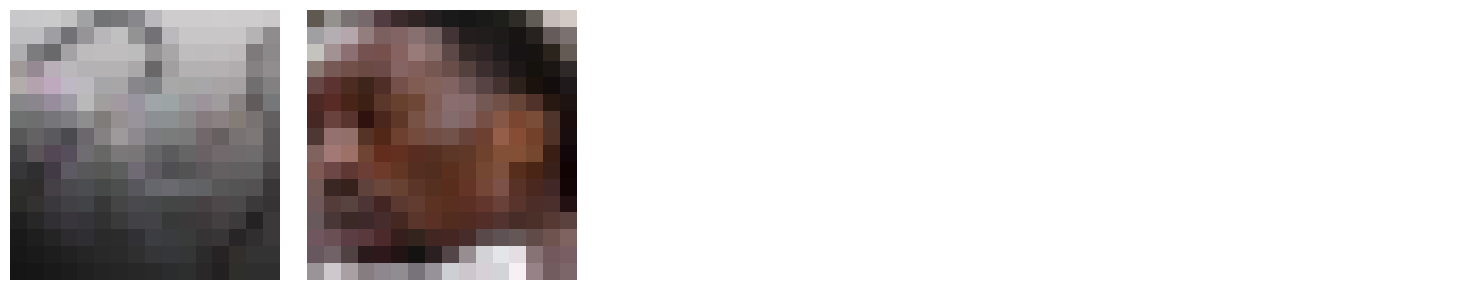

In [41]:
# Collect true labels, predictions, and misclassified images
true_labels = []
predicted_labels = []
false_positive_images = []  # NOT Lebron classified as Lebron
false_negative_images = []  # Lebron classified as NOT Lebron
false_positive_filenames = []
false_negative_filenames = []

model.eval()
with torch.no_grad():
    for batch_idx, (imgs, labels) in enumerate(test_loader):
        imgs, labels = imgs.to(device), labels.float().unsqueeze(1).to(device)
        logits = model(imgs)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())
        
        # Identify misclassified images
        for img, label, pred, idx in zip(imgs, labels, preds, range(len(labels))):
            dataset_idx = test_set.indices[batch_idx * test_loader.batch_size + idx]  # Get the original dataset index
            filename = full_ds.samples[dataset_idx][0]  # Retrieve the filename from the dataset
            if label.item() == 0 and pred.item() == 1:  # False Positive
                false_positive_images.append(img.cpu())
                false_positive_filenames.append(filename)
            elif label.item() == 1 and pred.item() == 0:  # False Negative
                false_negative_images.append(img.cpu())
                false_negative_filenames.append(filename)

# Display False Positives (NOT Lebron classified as Lebron)
if false_positive_images:
    num_images = len(false_positive_images)
    print(f"False Negatives (Lebron classified as not Lebron): {num_images}")
    
    # Calculate grid size
    cols = 5  # Number of images per row
    rows = math.ceil(num_images / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration
    
    for i, (img, filename) in enumerate(zip(false_positive_images, false_positive_filenames)):
        img = img.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Unnormalize the image
        axes[i].imshow(img)
        axes[i].axis('off')
        # axes[i].set_title(f"False Negatives\nIndex: {filename}")
    
    # Hide unused axes
    for i in range(num_images, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No False Positives found.")

# Display False Negatives (Lebron classified as NOT Lebron)
if false_negative_images:
    num_images = len(false_negative_images)
    print(f"False Positives (NOT Lebron classified as Lebron): {num_images}")
    
    # Calculate grid size
    cols = 5  # Number of images per row
    rows = math.ceil(num_images / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration
    
    for i, (img, filename) in enumerate(zip(false_negative_images, false_negative_filenames)):
        img = img.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Unnormalize the image
        axes[i].imshow(img)
        axes[i].axis('off')
        # axes[i].set_title(f"False Positive\nIndex: {filename}")
    
    # Hide unused axes
    for i in range(num_images, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No False Negatives found.")

# Predict

In [13]:
from PIL import Image
import torch

# Reverse lookup so 0/1 → folder names (only if you want the class string)
idx_to_class = {v: k for k, v in train_set.dataset.class_to_idx.items()}
# └─ If you used the train/val sub-folder layout, swap `full_ds.dataset` for `train_set.dataset`

def predict_image(path: str,
                  model: torch.nn.Module = model,
                  transform=transform,
                  device: str = "cuda" if torch.cuda.is_available() else "cpu",
                  threshold: float = 0.5):
    """
    Runs a single-image prediction on a *binary* CNN.

    Returns
    -------
    dict
        A dictionary with keys:
        - 'probability' (float): P(class == 1)
        - 'label_idx' (int): 0 or 1
        - 'label_name' (str): Folder name if `idx_to_class` is defined.
        - 'class_probabilities' (dict): Probabilities for both classes.
    """
    # 1. Pre-process
    img = Image.open(path).convert("RGB")
    img.resize((128,128), Image.LANCZOS)  # Resize to match training size
    tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension

    # 2. Forward pass
    model.eval()
    with torch.no_grad():
        logit = model(tensor)  # shape [1, 1]
        prob = torch.sigmoid(logit).item()

    # 3. Post-process
    label_idx = int(prob > threshold)
    label_name = idx_to_class.get(label_idx, str(label_idx))

    # Class probabilities
    class_probabilities = {
        "Lebron": prob,
        "Other": 1 - prob
    }

    return {
        "probability": prob,
        "label_idx": label_idx,
        "label_name": label_name,
        "class_probabilities": class_probabilities
    }

In [21]:
result = predict_image("test_photos/lebron1.jpg")
print(f"Predicted class: {result['label_name']} "
      f"(p = {result['probability']:.2%})")
print("Class probabilities:")
for class_name, prob in result['class_probabilities'].items():
    print(f"  {class_name}: {prob:.2%}")

# if result['label_name'] == "lebron":
#     print(f"Lebron is detected, probability: {result['label_name']} {result['probability']:.2%}")
# else:
#     print(f"Lebron is not detected, probability: {result['label_name']} {result['probability']:.2%}")

Predicted class: lebron (p = 0.00%)
Class probabilities:
  Lebron: 0.00%
  Other: 100.00%
